(simple_partition_mod)=
# Part I: Known number of Partitions

In this section of the tutorial, we demonstrate how BayesBay can be utilized to infer the piecewise function given prior knowledge of the number of segments composing it. This is achieved by dividing the domain into nine partitions, defined by a [1-D Voronoi tessellation](../api/generated/bayesbay.discretization.Voronoi1D), while treating the positions of the Voronoi sites as unknown. For a trans-dimensional approach, where the number of partitions is an unknown itself, please refer to the [Part II: Trans-dimensional Modeling](transd_partition_mod).

## Import libraries and define constants

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bayesbay.discretization import Voronoi1D
from bayesbay.prior import UniformPrior
from bayesbay.parameterization import Parameterization
from bayesbay import Target, LogLikelihood, BayesianInversion
np.random.seed(30)

In [2]:
X_DATA = np.linspace(0, 10, 100) # 100 data points
NOISE_STD = 5

In [3]:
@np.vectorize
def piecewise_function(x):
    if x <= 1:
        return 1
    elif 1 < x <= 2.5:
        return 20
    elif 2.5 < x <= 3:
        return 0
    elif 3 < x <= 4:
        return -3
    elif 4 < x <= 6:
        return -10
    elif 6 < x <= 6.5:
        return -20
    elif 6.5 < x <= 8:
        return 25
    elif 8 < x <= 9:
        return 0
    elif 9 < x <= 10:
        return 10

## Observed data

In [4]:
d_obs = piecewise_function(X_DATA) + np.random.normal(0, NOISE_STD, X_DATA.size)

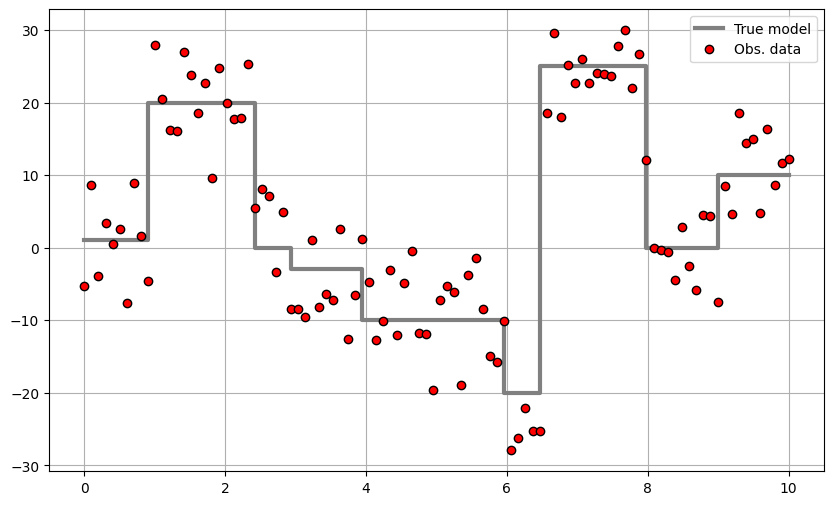

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.step(X_DATA, piecewise_function(X_DATA), 'gray', lw=3, label='True model')
ax.plot(X_DATA, d_obs, 'ro', markeredgecolor='k', label='Obs. data')
ax.legend()
ax.grid()
plt.show()

## Inference parameterization

In [6]:
y = UniformPrior('y', vmin=-35, vmax=35, perturb_std=3.5)
voronoi = Voronoi1D(
    name="voronoi", 
    vmin=0,
    vmax=10,
    perturb_std=0.75,
    n_dimensions=9,
    parameters=[y], 
    birth_from='prior'
)
parameterization = Parameterization(voronoi)

## Forward and Log Likelihood

In [7]:
def fwd_function(state):
    voro = state['voronoi']
    x_nuclei = voro['discretization']
    x_extents = Voronoi1D.compute_cell_extents(x_nuclei)
    x1 = x_extents[0]
    indexes = []
    indexes.extend([0] * np.flatnonzero(X_DATA <= x1).size)
    for i, extent in enumerate(x_extents[1:], 1):
        if extent == 0:
            idx_size = np.flatnonzero(X_DATA > x1).size
        else:
            x2 = x1 + x_extents[i]
            idx_size = np.flatnonzero((X_DATA > x1) & (X_DATA <= x2)).size
            x1 = x2
        indexes.extend([i] * idx_size)
        
    d_pred = voro['y'][indexes]
    return d_pred

In [8]:
target = Target("d_obs", 
                d_obs, 
                std_min=0, 
                std_max=20, 
                std_perturb_std=2)

log_likelihood = LogLikelihood(targets=target, fwd_functions=fwd_function)

## Bayesian Inference

In [9]:
inversion = BayesianInversion(
    parameterization=parameterization, 
    log_likelihood=log_likelihood,
    n_chains=20
)

inversion.run(
    sampler=None, 
    n_iterations=400_000, 
    burnin_iterations=50_000, 
    save_every=40,
    verbose=False
)

In [10]:
for chain in inversion.chains:
    chain.print_statistics()

Chain ID: 0
TEMPERATURE: 1
EXPLORED MODELS: 400000
ACCEPTANCE RATE: 153966/400000 (38.49 %)
PARTIAL ACCEPTANCE RATES:
	NoisePerturbation(d_obs): 19269/80243 (24.01%)
	ParamPerturbation(voronoi.discretization): 12175/79861 (15.25%)
	ParamPerturbation(voronoi.y): 122522/239896 (51.07%)
Chain ID: 1
TEMPERATURE: 1
EXPLORED MODELS: 400000
ACCEPTANCE RATE: 143310/400000 (35.83 %)
PARTIAL ACCEPTANCE RATES:
	NoisePerturbation(d_obs): 18280/79988 (22.85%)
	ParamPerturbation(voronoi.discretization): 9919/79973 (12.40%)
	ParamPerturbation(voronoi.y): 115111/240039 (47.96%)
Chain ID: 2
TEMPERATURE: 1
EXPLORED MODELS: 400000
ACCEPTANCE RATE: 159921/400000 (39.98 %)
PARTIAL ACCEPTANCE RATES:
	NoisePerturbation(d_obs): 20610/80260 (25.68%)
	ParamPerturbation(voronoi.discretization): 12862/80084 (16.06%)
	ParamPerturbation(voronoi.y): 126449/239656 (52.76%)
Chain ID: 3
TEMPERATURE: 1
EXPLORED MODELS: 400000
ACCEPTANCE RATE: 150881/400000 (37.72 %)
PARTIAL ACCEPTANCE RATES:
	NoisePerturbation(d_obs): 1

## Results

In [11]:
results = inversion.get_results(concatenate_chains=True)
percentiles = 10, 90
statistics = Voronoi1D.get_tessellation_statistics(
    results['voronoi.discretization'], 
    results['voronoi.y'], 
    X_DATA, 
    percentiles=percentiles
    )

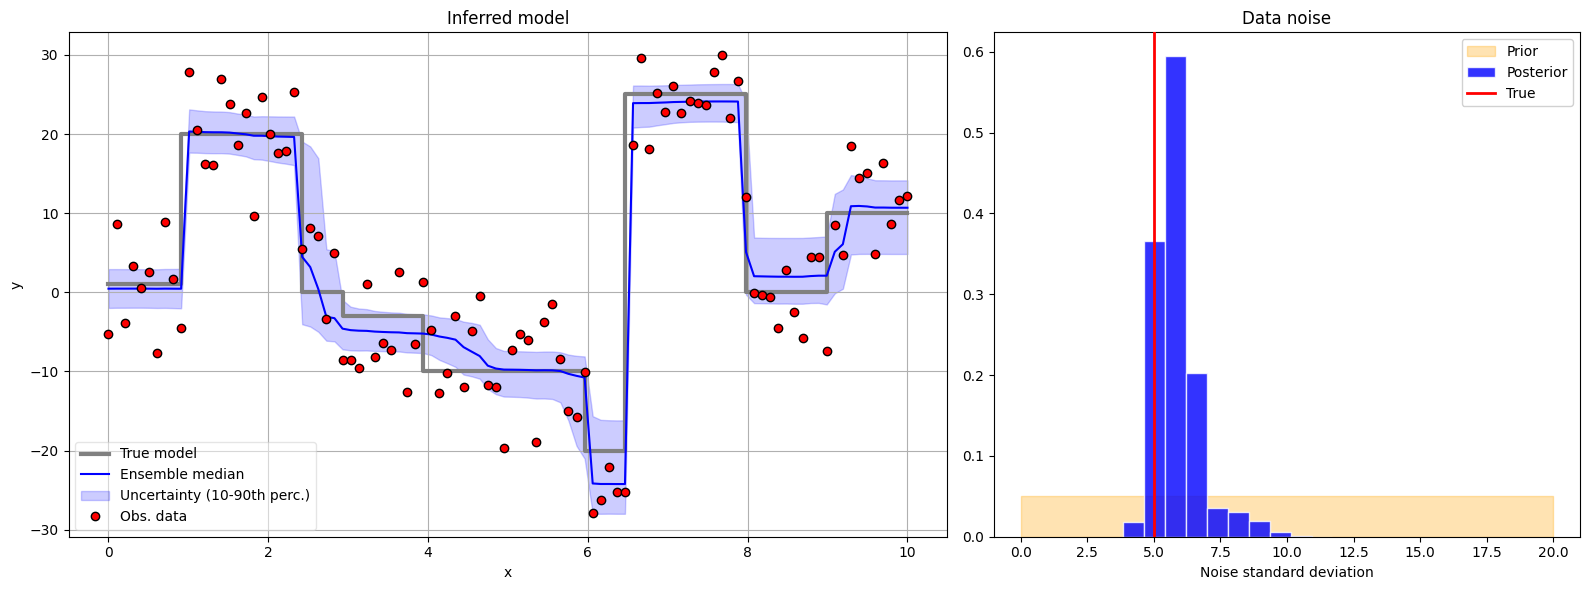

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6), gridspec_kw={'width_ratios': [1.5, 1]})

ax1.step(X_DATA, piecewise_function(X_DATA), 'gray', lw=3, label='True model')
ax1.plot(X_DATA, statistics['median'], 'b', label='Ensemble median')
ax1.fill_between(X_DATA, 
                *statistics['percentiles'], 
                color='b', 
                alpha=0.2, 
                label='Uncertainty (%s-%sth perc.)'%(percentiles))
ax1.plot(X_DATA, d_obs, 'ro', markeredgecolor='k', label='Obs. data')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.legend(framealpha=0.5)
ax1.grid()
ax1.set_title('Inferred model')

ax2.fill_between([target.std_min, target.std_max], 
                 1 / (target.std_max - target.std_min), 
                 alpha=0.3, 
                 color='orange',
                 label='Prior')
ax2.hist(results['d_obs.std'], 
         color='b',
         alpha=0.8, 
         density=True, 
         bins=10, 
         ec='w', 
         label='Posterior')
ax2.axvline(x=NOISE_STD, color='r', lw=2, alpha=1, label='True', zorder=100)
ax2.set_xlabel('Noise standard deviation')
ax2.legend(framealpha=0.9)
ax2.set_title('Data noise')
plt.tight_layout()
plt.show()